https://www.kaggle.com/bobazooba/thousands-of-questions-about-love

In [12]:
import os
import re
import nltk
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import model_selection
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pymorphy2
import pymystem3
from tqdm import tqdm

In [13]:
import smart_open
smart_open.open = smart_open.smart_open
import gensim
import gensim.downloader as gensim_api
import multiprocessing

In [14]:
from tensorflow.keras import models, layers, preprocessing as kprocessing, Sequential

Функция для преобразования текста (удаление стоп-слов, лемматизация (приведение к начальной форме)):

In [15]:
max_text_length = 200
morph = pymorphy2.MorphAnalyzer()
mystem = pymystem3.Mystem()

def normalize(text):
    words = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    
    sw = stopwords.words('russian')
    lst_text = [word for word in words if word not in sw][:max_text_length]
    
    # Лемматизация
    words = [morph.parse(word)[0].normal_form for word in words]
    
    return " ".join(words)

def normalizePymystem(text):
    tokens = mystem.analyze(text)
    words = []
    for t in tokens:
        if 'analysis' in t.keys():
            if t['analysis'] != []:
                words.append(t['analysis'][0]['lex'])
            else:
                words.append(t['text'])
    return " ".join(words)

#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger_ru')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IksaritsaNI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
love = pd.read_json("../resources/love.jsonl", lines=True)[['question', 'comment', 'sub_category']]
#love["text"] = love["question"] + love["comment"]
#love['text'] = love[['question', 'comment']].agg(' '.join, axis=1)
love = love.replace("", float("NaN")).dropna().drop_duplicates(ignore_index=True)
love

,question,comment,sub_category
0,С мужчиной не видимся,Поснакомились с мужчиной месяц назад. Интересн...,relations
1,"30 лет для 33 летнего мужика, это очень старая...","даже если ее и не любит, а как инкубатор?",relations
2,Нормально ли поведение мужчины?,"Нормально ли поведение мужчины,?!Написал снача...",relations
3,Почему один парень на работе ни с того ни с се...,При этом других не трогает и она на него тоже ...,relations
4,Почему женщины не могут понять одну истину...?,"В последнее время часто встречаются женщины, к...",relations
...,...,...,...
38554,Здравствуйте! Что делать? Объясните,"Короче моя подруга сегодня сказала, что я стра...",friendship
38555,Как понять нравлюсь ли я парню?,Мы учимся в одной группе. Иногда общаемся... Ч...,friendship
38556,есть привычка отбирать людей по статусу и поло...,"как бы сказать, мне приятно общаться с богатым...",friendship
38557,"Как назвать человека, который помогает, даде е...","Не согу вспомнить слово, вот ситуация, тебе ну...",friendship


In [17]:
love['sub_category'].value_counts()

divorsing     8840
relations     7453
friendship    7386
loving        6077
dating        5337
love_other    3466
Name: sub_category, dtype: int64

In [18]:
res = []

for cat in love['sub_category'].unique():
    tmp = love[love.sub_category == cat]
    #tmp = tmp.sample(frac=1)
    tmp = tmp[:1500]
    res.append(tmp)

love = pd.concat(res).reset_index(drop=True)
love

,question,comment,sub_category
0,С мужчиной не видимся,Поснакомились с мужчиной месяц назад. Интересн...,relations
1,"30 лет для 33 летнего мужика, это очень старая...","даже если ее и не любит, а как инкубатор?",relations
2,Нормально ли поведение мужчины?,"Нормально ли поведение мужчины,?!Написал снача...",relations
3,Почему один парень на работе ни с того ни с се...,При этом других не трогает и она на него тоже ...,relations
4,Почему женщины не могут понять одну истину...?,"В последнее время часто встречаются женщины, к...",relations
...,...,...,...
8995,Объясните поведение парня?,Познакомилась через знакомого с одним парнем. ...,friendship
8996,"Отец назвал шлюхой, устроил скандал",Дело обстоит так. Я встречаюсь с молодым челов...,friendship
8997,"Как думаете, почему он не пишет?",Общаемся с другом каждый день и так то пишет п...,friendship
8998,мне 16 лет у меня раннее половое созревание го...,а какой то противный и ущербный. Как его грубе...,friendship


In [19]:
cleaned = []

for i in tqdm(range(love.shape[0])):
    cleaned.append(normalize(love.comment.iloc[i]))
    
love['cleaned'] = cleaned
love

#from pymystem3 import Mystem
#m = Mystem()
#love["cleaned"] = love.comment.apply(lambda text: ''.join(m.lemmatize(text)))
#love

100%|██████████████████████████████████████████████████████████████████████████████| 9000/9000 [02:46<00:00, 54.01it/s]


,question,comment,sub_category,cleaned
0,С мужчиной не видимся,Поснакомились с мужчиной месяц назад. Интересн...,relations,поснакомиться с мужчина месяц назад интересно ...
1,"30 лет для 33 летнего мужика, это очень старая...","даже если ее и не любит, а как инкубатор?",relations,даже если она и не любить а как инкубатор
2,Нормально ли поведение мужчины?,"Нормально ли поведение мужчины,?!Написал снача...",relations,нормально ли поведение мужчина написать сначал...
3,Почему один парень на работе ни с того ни с се...,При этом других не трогает и она на него тоже ...,relations,при это другой не трогать и она на он тоже не ...
4,Почему женщины не могут понять одну истину...?,"В последнее время часто встречаются женщины, к...",relations,в последний время часто встречаться женщина ко...
...,...,...,...,...
8995,Объясните поведение парня?,Познакомилась через знакомого с одним парнем. ...,friendship,познакомиться через знакомый с один парень гул...
8996,"Отец назвал шлюхой, устроил скандал",Дело обстоит так. Я встречаюсь с молодым челов...,friendship,дело обстоять так я встречаться с молодой чело...
8997,"Как думаете, почему он не пишет?",Общаемся с другом каждый день и так то пишет п...,friendship,общаться с друг каждый день и так то писать пе...
8998,мне 16 лет у меня раннее половое созревание го...,а какой то противный и ущербный. Как его грубе...,friendship,а какой то противный и ущербный как он грубый ...


In [20]:
train, test = model_selection.train_test_split(love, test_size=0.2)

In [21]:
corpus = train["cleaned"]

# Сформируем список юниграмм
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

corpus

4580    вот обидно быть так обидно я стройный всегда в...
4860    привет весь у я такой ситуация мы с девушка ме...
8659    общаться с подруга каникулы не видеться написа...
8011    нравиться один подруга очень но взаимность ник...
7936    я друг перестать сам постоянно писать звонить ...
                              ...                        
550     поправить опрос задать ранее другой тело так д...
1623    хороший подруга я написать что один девчонка р...
3720    влюбиться в один девчонка оба год ещё этот вес...
7272    что вы подумать о парень г который всё время м...
369     встречаться с мужчина на расстояние жить в раз...
Name: cleaned, Length: 7200, dtype: object

Обучаем модель Word2Vec для построения вложений слов:

In [22]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=100,   
            window=5, min_count=1, sg=1, epochs=20)

In [23]:
len(nlp.wv)

19762

Преобразование текста в вектор чисел на основе построенных с помощью word2Vec вложений слов:

In [24]:
def text_to_vec(text):
    words = text.split(" ")
    vec = [nlp.wv[word] for word in words if word in nlp.wv]
    return np.asarray(vec).reshape(-1)

In [25]:
love["vec"] = love.cleaned.apply(lambda text: text_to_vec(text))

In [26]:
love

,question,comment,sub_category,cleaned,vec
0,С мужчиной не видимся,Поснакомились с мужчиной месяц назад. Интересн...,relations,поснакомиться с мужчина месяц назад интересно ...,"[-0.0027745094, 0.04428424, -0.05474182, -0.00..."
1,"30 лет для 33 летнего мужика, это очень старая...","даже если ее и не любит, а как инкубатор?",relations,даже если она и не любить а как инкубатор,"[0.22311522, -0.42660832, -0.044856627, -0.017..."
2,Нормально ли поведение мужчины?,"Нормально ли поведение мужчины,?!Написал снача...",relations,нормально ли поведение мужчина написать сначал...,"[0.07927462, 0.12509462, -0.019550055, -0.6315..."
3,Почему один парень на работе ни с того ни с се...,При этом других не трогает и она на него тоже ...,relations,при это другой не трогать и она на он тоже не ...,"[-0.41877562, 0.7246047, 0.43740764, -0.644091..."
4,Почему женщины не могут понять одну истину...?,"В последнее время часто встречаются женщины, к...",relations,в последний время часто встречаться женщина ко...,"[-0.14934734, 0.045990016, 0.010010665, -0.067..."
...,...,...,...,...,...
8995,Объясните поведение парня?,Познакомилась через знакомого с одним парнем. ...,friendship,познакомиться через знакомый с один парень гул...,"[0.06367826, 0.21411945, 0.22030823, -0.607924..."
8996,"Отец назвал шлюхой, устроил скандал",Дело обстоит так. Я встречаюсь с молодым челов...,friendship,дело обстоять так я встречаться с молодой чело...,"[0.7060436, 0.13077635, 0.098412074, -0.384651..."
8997,"Как думаете, почему он не пишет?",Общаемся с другом каждый день и так то пишет п...,friendship,общаться с друг каждый день и так то писать пе...,"[0.12196497, 0.3165825, -0.13556094, -0.094488..."
8998,мне 16 лет у меня раннее половое созревание го...,а какой то противный и ущербный. Как его грубе...,friendship,а какой то противный и ущербный как он грубый ...,"[-0.3330533, 0.28841275, -0.07866067, 0.131439..."


Выравниваем все векторизованные тексты по длине:

In [27]:
max_words = max(love.vec.apply(lambda vec: len(vec)))
max_words

68100

In [28]:
pad_data = kprocessing.sequence.pad_sequences(
    love.vec, 
    maxlen=max_words, 
    padding="post", 
    truncating="post",
    dtype="float32"
)

Проецируем тексты на двумерное пространство UMAP'ом:

In [29]:
fit = umap.UMAP(
    n_neighbors=50,
    min_dist=0.01,
    n_components=2,
    metric="euclidean",
    random_state=42
)
    
umap_result = fit.fit_transform(pad_data)

Отображаем результат проекции:

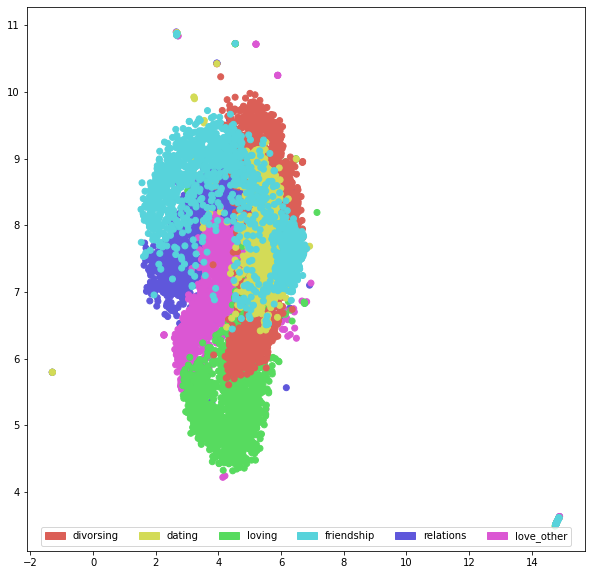

In [30]:
keys = list(love["sub_category"].value_counts().keys())
themes_dict = {keys[i]:i for i in range(len(keys))}
colors = [sns.color_palette("hls", len(themes_dict))[x] for x in love["sub_category"].map(themes_dict)]

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=colors)

patches = [mpatches.Patch(color=sns.color_palette("hls", len(themes_dict))[i], label=keys[i]) for i in range(len(keys))]
plt.legend(handles=patches, ncol=10, loc="lower center")

Преобразуем тексты в виде n-грамм в последовательности индексов слов в матрице вложений:

In [31]:
train, test = model_selection.train_test_split(love, test_size=0.2)
test.sub_category.value_counts()

love_other    321
friendship    309
dating        300
relations     295
loving        288
divorsing     287
Name: sub_category, dtype: int64

In [32]:
x_train = kprocessing.sequence.pad_sequences(
    train.vec, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

Составляем n-граммы для тестовой выборки:

In [33]:
# Выравнивание по длине
x_test = kprocessing.sequence.pad_sequences(
    test.vec, 
    maxlen=max_words,
    padding="post", 
    truncating="post"
)

Строим матрицу вложений размером <число_слов> * <длина_вложения_слова>:

In [40]:
max_words = max(love.vec.apply(lambda vec: len(vec)))
num_classes = len(np.unique(love.sub_category))

In [51]:
model = Sequential()
model.add(layers.Dense(3000, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(300))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 3000)              204303000 
_________________________________________________________________
activation_9 (Activation)    (None, 3000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 300)               900300    
_________________________________________________________________
activation_10 (Activation)   (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 1806      
_________________________________________________________________
activation_11 (Activation)   (None, 6)                 0         
Total params: 205,205,106
Trainable params: 205,205,106
Non-trainable params: 0
________________________________________

In [52]:
y_train = train["sub_category"].values
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

y_test = test["sub_category"].values
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_test))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_test = np.array([inverse_dic[y] for y in y_test])

In [53]:
training = model.fit(x=x_train, y=y_train, batch_size=100, 
                     epochs=20, shuffle=True, verbose=0, 
                     validation_split=0.3)

In [54]:
# Dense(3000), Dense(300), batch_size=100, epochs=20
res = list(map(lambda x: list(x).index(max(x)), model.predict(x_test)))
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.22      0.32      0.26       300
           1       0.30      0.25      0.27       287
           2       0.27      0.28      0.27       309
           3       0.27      0.19      0.23       321
           4       0.22      0.19      0.21       288
           5       0.20      0.21      0.20       295

    accuracy                           0.24      1800
   macro avg       0.25      0.24      0.24      1800
weighted avg       0.25      0.24      0.24      1800



In [48]:
# Dense(5000), batch_size=100, epochs=20
res = list(map(lambda x: list(x).index(max(x)), model.predict(x_test)))
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.22      0.22      0.22       300
           1       0.29      0.33      0.31       287
           2       0.24      0.25      0.25       309
           3       0.25      0.25      0.25       321
           4       0.21      0.19      0.20       288
           5       0.21      0.20      0.21       295

    accuracy                           0.24      1800
   macro avg       0.24      0.24      0.24      1800
weighted avg       0.24      0.24      0.24      1800



In [44]:
# Dense(3000), batch_size=50, epochs=20
res = list(map(lambda x: list(x).index(max(x)), model.predict(x_test)))
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.24      0.24      0.24       300
           1       0.27      0.32      0.29       287
           2       0.27      0.25      0.26       309
           3       0.28      0.26      0.27       321
           4       0.20      0.19      0.19       288
           5       0.21      0.22      0.21       295

    accuracy                           0.25      1800
   macro avg       0.25      0.25      0.25      1800
weighted avg       0.25      0.25      0.25      1800

